In [1]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

In [3]:
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    return

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

In [29]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

It is quite common to stack multiple layers of cells. This gives you a deep RNN.

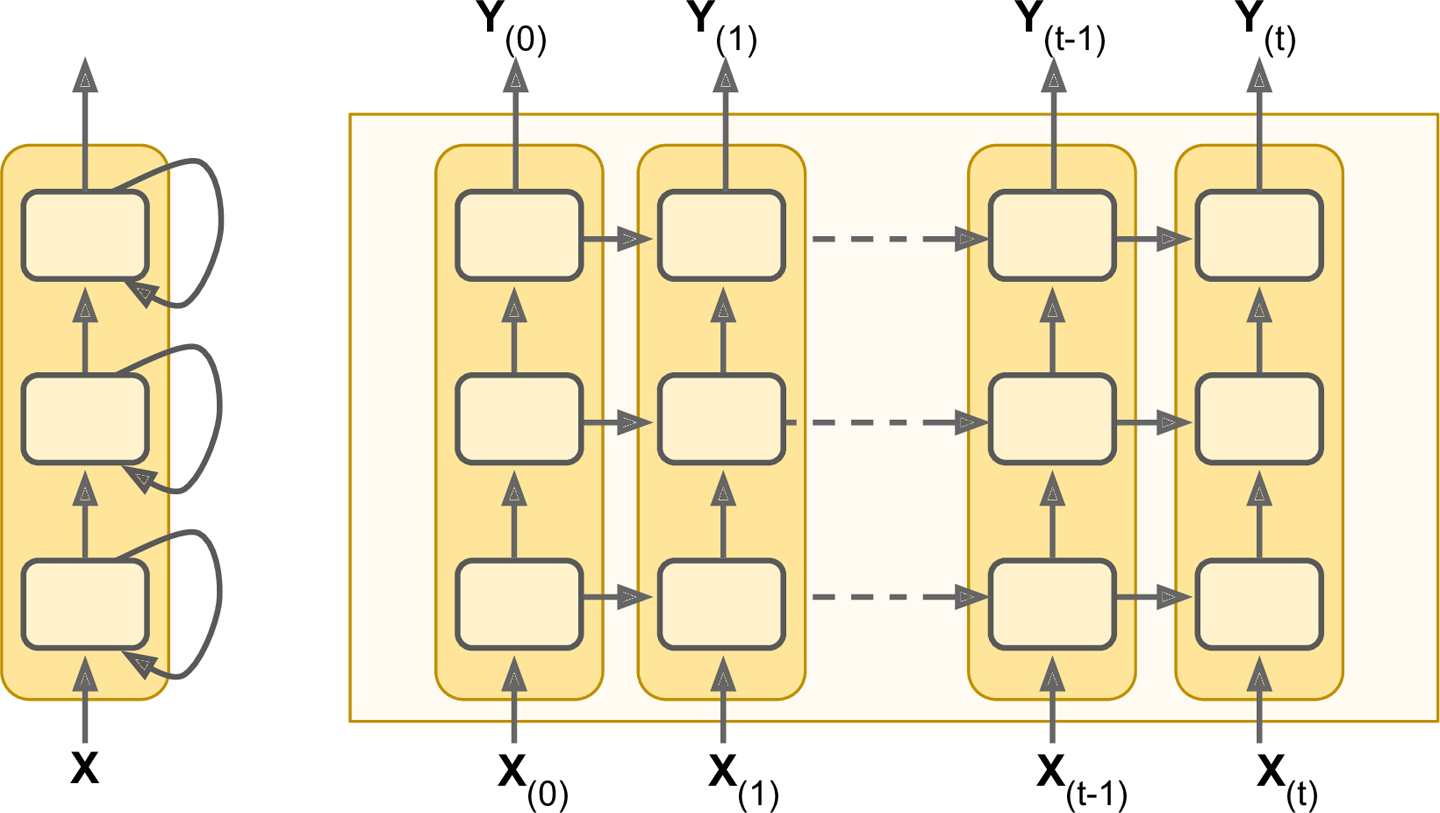

In [4]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [7]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

ValueError: Variable rnn/multi_rnn_cell/cell_0/basic_rnn_cell/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\Users\Chauh\Anaconda2\envs\mlhandson\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()
  File "C:\Users\Chauh\Anaconda2\envs\mlhandson\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Chauh\Anaconda2\envs\mlhandson\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)


In [9]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [10]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [11]:
outputs_val.shape

(2, 5, 100)

## Distributing a Deep RNN Across Multiple GPUs

In [ ]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

This fails because a BasicRNNCell is a cell factory, not a cell per se (as mentioned earlier); no cells get created when you create the factory, and thus no variables do either. The device block is simply ignored. The cells actually get created later. When you call dynamic_rnn(), it calls the MultiRNNCell, which calls each individual BasicRNNCell, which create the actual cells (including their variables). Unfortunately, none of these classes provide any way to control the devices on which the variables get created. If you try to put the dynamic_rnn() call within a device block, the whole RNN gets pinned to a single device. So are you stuck? Fortunately not! The trick is to create your own cell wrapper:

In [16]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [17]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

This wrapper simply proxies every method call to another cell, except it wraps the __call__() function within a device block.2 Now you can distribute each layer on a different GPU:

In [19]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Do not set state_is_tuple=False, or the MultiRNNCell will concatenate all the cell states into a single tensor, on a single GPU.

In [20]:
init = tf.global_variables_initializer()

In [21]:
with tf.Session() as sess:
    init.run()
    outputs_val = sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)})

In [22]:
print(outputs_val.shape)

(2, 20, 100)


## Dropout

In [23]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [24]:
keep_prob = 0.5

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [26]:
states

(<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>)

In [27]:
rnn_outputs

<tf.Tensor 'rnn/transpose:0' shape=(?, 20, 100) dtype=float32>

In [28]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
# we want the output from rnn layer to be n_outputs dimensional
# the outputs will be n_layers * n_neurons dimensional
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Unfortunately, this code is only usable for training, because the `DropoutWrapper` class has no `training` parameter, so it always applies dropout, even when the model is not being trained, so we must first train the model, then create a different model for testing, without the `DropoutWrapper`.

In [30]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            print(iteration, "Training MSE:", mse)
    
    saver.save(sess, "./checkpoints/my_dropout_time_series_model")

0 Training MSE: 14.0255
100 Training MSE: 5.57734
200 Training MSE: 4.71697
300 Training MSE: 3.68246
400 Training MSE: 3.19697
500 Training MSE: 3.86447
600 Training MSE: 3.26248
700 Training MSE: 3.05885
800 Training MSE: 3.33709
900 Training MSE: 4.55394
